# Complex Reactions in PBR & CSTR

First we need to set up the notebook to draw the plots inline, and import some libraries--we'll nearly always start with this:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.integrate
import scipy.optimize

## Reactions
$$\require{mhchem}$$
$$\ce{A +2B-> C}\tag{Reaction 1}$$
$$\ce{2A +3C -> D}\tag{Reaction 2}$$


## Part (a)
A PBR with gas phase reactions will be simulated.  It is given that the reactions have elementary kinetics--a highly dubious assumption, but we proceed...

We are given reaction rates in terms of specific components:
\begin{align*}
-r'_{1A} &= k_{1A} C_A C_B^2\\
-r'_{2C} &= k_{2C} C_A^2 C_C^3\\
\end{align*}

We will use the following rate notation for the reactions:
\begin{align*}
r'_1 &= k_1 C_A C_B^2\\
r'_2 &= k_2 C_A^2 C_C^3\\
\end{align*}

Where
\begin{align*}
k_1 &= k_{1A}/1\\
k_2 &= k_{2C}/3
\end{align*}

Our mole balances become
\begin{align*}
\frac{dF_A}{dW} &= - r_1 - 2r_2\\
\frac{dF_B}{dW} &= -2r_1 \\
\frac{dF_C}{dW} &= +r_1 -3 r_2\\
\frac{dF_D}{dW} &= +r_2
\end{align*}



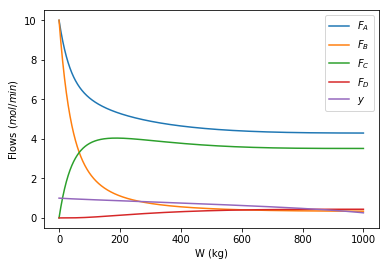

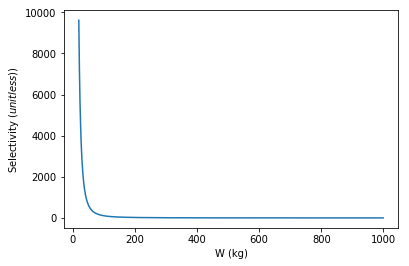

4.29341340739 0.340841717262 3.51406796451 0.438503725619 0.257857512755 8.01376991621


In [17]:
Ct0 = 0.2 #M
Ft0 = 20 # mol/min


Fa0 = 0.5 * Ft0
Fb0 = 0.5 * Ft0
Fc0 = 0
Fd0 = 0

alpha = 0.0019 # 1/kg
y0 = 1 # unitless pressure ratio

k1A = 100 # L3/mol2/kgcat/min
k2C = 1500 # L5/mol4/kgcat/min

k1 = k1A/1
k2 = k2C/3

def dFvectordW(Fvector, W):
    """
    Differential equation for flows as a function of weight of catalyst
    """
    Fa, Fb, Fc, Fd, y = Fvector # unpack values from vector into four variables
    Ft = Fa + Fb + Fc + Fd
    # concentrations that appear in rates
    Ca = Ct0 * Fa / Ft * y
    Cb = Ct0 * Fb / Ft * y
    Cc = Ct0 * Fc / Ft * y
    # rates of reactions
    r1 = k1 * Ca * Cb**2
    r2 = k2 * Ca**2 * Cc**3
    # rates of generation of species
    ra = -1 * r1 -2 * r2
    rb = -2 * r1
    rc = +1 * r1 -3 * r2
    rd = +1 * r2
    # Differential equations for rates of change of concentrations
    dFadW = ra
    dFbdW = rb
    dFcdW = rc
    dFddW = rd
    # Differential equation for pressure drop ratio y
    dydW = -alpha / (2 * y) * (Ft/Ft0)
    return [dFadW, dFbdW, dFcdW, dFddW, dydW] # pack up values into a vector

steps = np.linspace(0, 1000, num=1001) # steps for plots
Fvector0 = [Fa0, Fb0, Fc0, Fd0, y0] # initial values
Y_result = scipy.integrate.odeint(dFvectordW, Fvector0, steps) 
# extract columns by transposing matrix and splitting into three variables
Fa, Fb, Fc, Fd, y = Y_result.T 

# Do some plotting
plt.plot(steps, Fa, label='$F_A$')
plt.plot(steps, Fb, label='$F_B$')
plt.plot(steps, Fc, label='$F_C$')
plt.plot(steps, Fd, label='$F_D$')
plt.plot(steps, y, label='$y$')
plt.legend(loc="best")
plt.xlabel('W (kg)')
plt.ylabel('Flows ($mol/min$)')
plt.show()

# Look at selectivity
plt.plot(steps[20:1000],Fc[20:1000]/Fd[20:1000])
plt.legend(loc="best")
plt.xlabel('W (kg)')
plt.ylabel('Selectivity ($unitless$))')
plt.show()
print(Fa[1000],Fb[1000],Fc[1000],Fd[1000],y[1000],Fc[1000]/Fd[1000])



# don't pay attention to this
# first define the function for any array we call concentrations
# so that we can re-use it later
##def report_max(concentrations, timesteps):
##    max_R = concentrations.max()
#    print "Maximum concentration is {0:.1g} mol/dm3".format(max_R)
##    index = concentrations.argmax()
##    max_time = timesteps[index]
##    stepsize = timesteps[1]
#    print "It occurs at about {0:.0f} +/- {1:.0f} seconds".format(
#                                                        max_time, stepsize)
# now call the function on the current Cr array
##report_max(Cr, timesteps)

## Part (a--supplemental)
In assignment 6, we will be simulating varying temperature.
While it's perfectly fine to re-run the same block 3 times, there's nifty approaches to doing it all in one shot if you're interested.
Here's a code that would get the job done
We set it up with temperature as a variable in the first place, to avoid code repetition, here goes.
We can make some reusable functions

In [18]:
Ct100 = 0.2 #M
Ft0 = 20 # mol/min

Fa0 = 0.5 * Ft0
Fb0 = 0.5 * Ft0
Fc0 = 0
Fd0 = 0

alpha = 0.0019 # 1/kg
y0 = 1 # unitless pressure ratio

k1A = 100 # L3/mol2/kgcat/min
k2C = 1500 # L5/mol4/kgcat/min

k1 = k1A/1
k2 = k2C/3

def modify_k(k_at_100C, Ea, new_temperature_in_C):
    """
    This function takes the k at 100C, the activation 
    energy in kcal/mol, and a new temperature,
    and returns the k at that new temperature
    """
    R_kcal = 0.00198720413 # kcal/mol/K
    Tref = 100. + 273.15
    T = new_temperature_in_C + 273.15
    return k_at_100C * np.exp(-1*Ea/R_kcal * (1./T - 1./Tref))

def dFvectordW(Fvector, W, T_in_C, Ct0):
    """
    Differential equation for flows as a function of weight of catalyst
    """
    Fa, Fb, Fc, Fd, y = Fvector # unpack values from vector into four variables
    Ft = Fa + Fb + Fc + Fd
    # concentrations that appear in rates
    Ca = Ct0 * Fa / Ft * y
    Cb = Ct0 * Fb / Ft * y
    Cc = Ct0 * Fc / Ft * y

    # define the k1, k2 in this local scope
    k1 = modify_k(100/1, 35, T_in_C) # assumed an Ea of 35 kcal / mole for 1
    k2 = modify_k(1500/3, 40, T_in_C) # assumed an Ea of 40 kcal / mole for 2
    
    # rates of reactions
    r1 = k1 * Ca * Cb**2
    r2 = k2 * Ca**2 * Cc**3
    # rates of generation of species
    ra = -1 * r1 -2 * r2
    rb = -2 * r1
    rc = +1 * r1 -3 * r2
    rd = +1 * r2
    # Differential equations for rates of change of concentrations
    dFadW = ra
    dFbdW = rb
    dFcdW = rc
    dFddW = rd
    # Differential equation for pressure drop ratio y
    dydW = -alpha / (2 * y) * (Ft/Ft0)
    return [dFadW, dFbdW, dFcdW, dFddW, dydW] # pack up values into a vector

def integrate_plot_and_analyze(T_in_C):
    """
    This reusable function does the whole analysis,
    for a given temperature
    """
    T = T_in_C + 273.15 # K
    print ("Simulating at {0} Celsius which is {1} Kelvin".format(T_in_C, T))
    R = 8.314 # J/mol/K
    Ct0 = Ct100 * 373.15 / T # M 
    print ("Starting concentration = {A} mol/dm3".format(A=Ct0) )
    
    steps = np.linspace(0, 1000, num=1001) # steps for plots
    Fvector0 = [Fa0, Fb0, Fc0, Fd0, y0] # initial values
    
    # Now when we call the integrator, we have to pass in the T_in_C and Ct0.
    # This has to be in a "tuple" which is why we do `args=(T_in_C,Ct0,)`
    Y_result = scipy.integrate.odeint(dFvectordW, Fvector0, steps, args=(T_in_C,Ct0,)) # perform the integration

# extract columns by transposing matrix and splitting into individual variables
    Fa, Fb, Fc, Fd, y = Y_result.T 

# Do some plotting
    plt.plot(steps, Fa, label='$F_A$')
    plt.plot(steps, Fb, label='$F_B$')
    plt.plot(steps, Fc, label='$F_C$')
    plt.plot(steps, Fd, label='$F_D$')
    plt.plot(steps, y, label='$y$')
    plt.legend(loc="best")
    plt.xlabel('W (kg)')
    plt.ylabel('Flows ($mol/min$)')
    plt.show()



First check that the result at 100 C is the same as before,
Then use it at the two new temperatures.

Simulating at 100 Celsius which is 373.15 Kelvin
Starting concentration = 0.2 mol/dm3


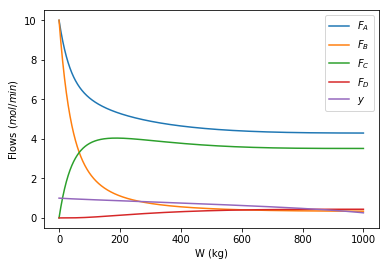

Simulating at 110 Celsius which is 383.15 Kelvin
Starting concentration = 0.1947801122275871 mol/dm3


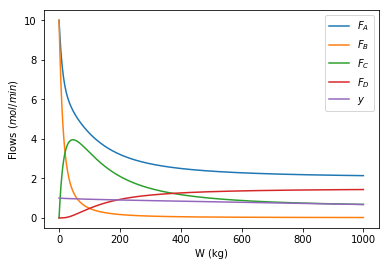

Simulating at 120 Celsius which is 393.15 Kelvin
Starting concentration = 0.18982576624697953 mol/dm3


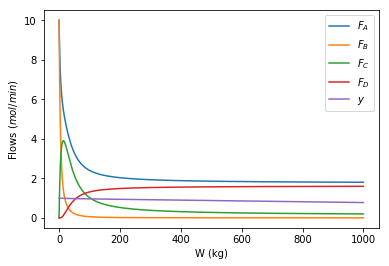

In [19]:
for temperature in [100, 110, 120]:
    integrate_plot_and_analyze(temperature)

## Part (b)
For a CSTR we have a set of nonlinear equations we must solve simultaneously. 
The simplest way is to do a mole balance, and create a set of differential equations 
for number of moles with respect to time, $d\mathbf{N}/dt$. At steady state 
we know $d\mathbf{N}/dt = 0$, so the differential equations become algebraic equations.

We'll set up $d\mathbf{N}/dt$ as a function of the exit concentrations $\mathbf{C}$ then use the `root` function from `scipy.optimize` to find the root of this equation  i.e. what values of $\mathbf{C}=[C_A, C_R, C_S]$ will give set the equation equal to zero ($d\mathbf{N}/dt=0$)?  Note:  this is $\bf{exactly}$ like using solver in Excel.  A plausible alternative would be to run a time-varying equation until it reaches steady state.

For each species $i$ the mole balance gives
\begin{align*}
\frac{dN_i}{dt} &= F_{i0} - F_i + r_i V\\
 &= C_{i0}v_0 - C_i v_0 + r_i V\\
 &= v_0(C_{i0} - C_i + r_i \tau )
\end{align*}


In [16]:
V = 2500 # L
v0 = 100 # L/min
tau = V/v0 # min

Ca0 = 2 # M
Cb0 = 2 # M
Cc0 = 0 # M
Cd0 = 0 # M

k1A = 10 # M**2 / min
k2C = 15 # M**4 / min

k1 = k1A/1
k2 = k2C/3
    
def dNvectordt(Cvector):
    """
    This is a differential equation for the number of moles
    of each species in the reactor, as function of time.
    At steady state it should equal zero.
    We must pass in the exit species concentrations in a vector.
    """
    Ca, Cr, Cc = Cvector 
    # rates of reactions
    r1 = k1 * Ca * Cb**2
    r2 = k2 * Ca**2 * Cc**3
    # rates of generation of species
    ra = -1 * r1 -2 * r2
    rb = -2 * r1
    rc = +1 * r1 -3 * r2
    rd = +1 * r2

    # Differential equations for rates of change of moles
    dNadt = v0 * ( Ca0 - Ca + ra * tau)
    dNbdt = v0 * ( Cb0 - Cb + rb * tau)
    dNcdt = v0 * ( Cc0 - Cc + rc * tau)
    dNddt = v0 * ( Cd0 - Cd + rd * tau)
    return [dNadt, dNbdt, dNcdt, dNddt]

guess = [Ca0/2, Ca0/2, Ca0/2, Ca0/2] # initial guess
result = scipy.optimize.root(dNvectordt, guess)

Ca, Cb, Cc, Cd = result.x

print ("")
print ("For a CSTR with spacetime = {0} seconds".format(tau))
for (label, value) in [('A',Ca),('B', Cb),('C',Cc),('D',Cd)]:
    print ("The concentration of {0} is {1:.4} M".format(label,value))


For a CSTR with spacetime = 25.0 seconds
The concentration of A is 0.5327 M
The concentration of B is 0.0848 M
The concentration of C is 0.193 M
The concentration of D is 0.2549 M
